# Kmeans Scratch

```python
import numpy as np
import matplotlib.pyplot as plt

class Kmeans:
    def __init__(self, n_clusters=3, max_iters=100, ):
        self.n_clusters = n_clusters
        self.max_iters = max_iters 
        self.cluster_centers = {}
        self.random = 42
        self.labels = None
        self.cluster_centers =  None
        
    def initialize_centroids(self, X):
        # takes random data point as the start point
        rng = np.random.default_rng(self.random)
        idx = rng.choice(len(X), size=self.n_clusters, replace=False)
        return X[idx]
    
    def assign_clusters(self, X, centroids):
        # calculate using aeuclidean distance
        labels = []
        for x in X:
            min_dis = float('inf')
            label = -1
            for idx, centroid in enumerate(centroids):
                distance = np.linalg.norm(x - centroid, axis=1)
                if distance < min_dis:
                    min_dis = distance
                    label = idx
            
            labels.append(label)
        return np.array(labels)
    
    def update_centroids(self, X, clusters):       
        for i in range(self.n_clusters):
            points = np.array(clusters[i]['points'])
                


            if points.shape[0] > 0:
                new_center = points.mean(axis=0)
                clusters[i]['center'] = new_center
                clusters[i]['points'] = []
        
        return clusters
    
    def fit(self, X):
        # intialize the centroids
        self.cluster_centers = self.initialize_centroids(X)
            
        for _ in range(self.max_iters):
            labels = self.assign_clusters(X, self.cluster_centers)
            # create dicrectory
            clusters = {
                i:{
                    'center': self.cluster_centers[i],
                    'points':[]
                } for i in range(self.n_clusters)
            }
            # add points to centroids    
            for x, label in zip(X, labels):
                clusters[label]['points'].append(x)
            
            # update centroids
            clusters = self.update_centroids(X, clusters)

            new_centers = np.array([clusters[i]['center']for i in range(self.n_clusters)])

            # check convergence
            if np.allclose(self.cluster_centers, new_centers):
                break

            self.cluster_centers = new_centers
        
        self.labels = self.assign_clusters(X, self.cluster_centers)
     
    def predict(self, X):
        labels = []

        for x in X:
            label = -1
            min_dist = float('inf')

            for idx, centroid in enumerate(self.cluster_centers):
                distance = np.linalg.norm(x-centroid)
                if distance < min_dist:
                    min_dist = distance
                    label = idx
            

            labels.append(label)
        return np.array(labels)
    
    def compute_inertia(self, X):
        inertia = 0
        for x, label in zip(X, self.labels):
            center = self.cluster_centers[label]
            inertia += np.linalg.norm(x - center) ** 2
        return inertia

    @staticmethod
    def elbow_method(X, max_k=10):
        inertias = []
        for k in range(1, max_k + 1):
            model = Kmeans(n_clusters=k)
            model.fit(X)
            inertia = model.compute_inertia(X)
            inertias.append(inertia)
        # Plot the elbow
        plt.plot(range(1, max_k + 1), inertias, 'bo-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia (WSS)')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        plt.show()
```
I add the elbow method in the class so we dont need to do it seperately

# DBscan Scratch

```python
import numpy as np

class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = None
        self.core_sample_indices = []

    def fit(self, X):
        n = len(X)
        self.labels = np.full(n, -1)  
        cluster_id = 0
        visited = np.zeros(n, dtype=bool)

        for idx in range(n):
            if visited[idx]:
                continue
            visited[idx] = True
            neighbors = self.region_query(X, idx)

            if len(neighbors) < self.min_samples:
                continue  
            else:
                self.expand_cluster(X, idx, neighbors, cluster_id, visited)
                cluster_id += 1

    def expand_cluster(self, X, idx, neighbors, cluster_id, visited):
        self.labels[idx] = cluster_id
        i = 0
        while i < len(neighbors):
            point_idx = neighbors[i]
            if not visited[point_idx]:
                visited[point_idx] = True
                new_neighbors = self.region_query(X, point_idx)
                if len(new_neighbors) >= self.min_samples:
                    neighbors = np.concatenate((neighbors, new_neighbors))
            if self.labels[point_idx] == -1:
                self.labels[point_idx] = cluster_id
            i += 1

    def region_query(self, X, idx):
        distances = np.linalg.norm(X - X[idx], axis=1)
        return np.where(distances <= self.eps)[0]

    def predict(self):
        return self.labels
```

# Implement Kmeans on Iris Dataset

## Import important Library and Models

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from Kmeans import Kmeans # import class Kmeans from file Kmeans
from DBscan import DBscan # import class DBscan from file DBscan

## Load Dataset

In [2]:
iris = datasets.load_iris()
X = iris.data
print(X.shape)
X

(150, 4)


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

## Preprocessing

In [3]:
# Normalize dataset
X = normalize(X)
X

array([[0.80377277, 0.55160877, 0.22064351, 0.0315205 ],
       [0.82813287, 0.50702013, 0.23660939, 0.03380134],
       [0.80533308, 0.54831188, 0.2227517 , 0.03426949],
       [0.80003025, 0.53915082, 0.26087943, 0.03478392],
       [0.790965  , 0.5694948 , 0.2214702 , 0.0316386 ],
       [0.78417499, 0.5663486 , 0.2468699 , 0.05808704],
       [0.78010936, 0.57660257, 0.23742459, 0.0508767 ],
       [0.80218492, 0.54548574, 0.24065548, 0.0320874 ],
       [0.80642366, 0.5315065 , 0.25658935, 0.03665562],
       [0.81803119, 0.51752994, 0.25041771, 0.01669451],
       [0.80373519, 0.55070744, 0.22325977, 0.02976797],
       [0.786991  , 0.55745196, 0.26233033, 0.03279129],
       [0.82307218, 0.51442011, 0.24006272, 0.01714734],
       [0.8025126 , 0.55989251, 0.20529392, 0.01866308],
       [0.81120865, 0.55945424, 0.16783627, 0.02797271],
       [0.77381111, 0.59732787, 0.2036345 , 0.05430253],
       [0.79428944, 0.57365349, 0.19121783, 0.05883625],
       [0.80327412, 0.55126656,

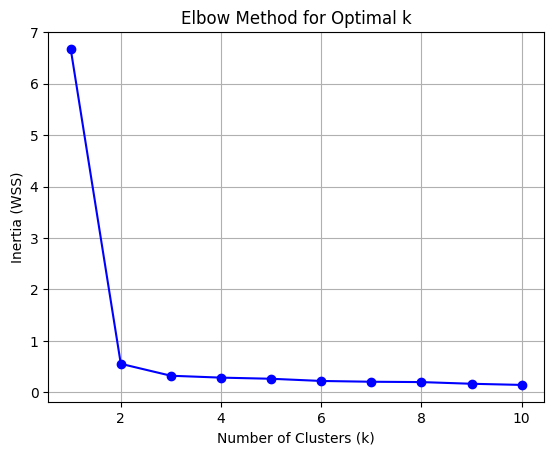

In [5]:
## Implement Kmeans Elbow methods
Kmeans.elbow_method(X)

## Implement Kmeans

In [11]:
# K = 3, based on the elbow methods
Kmeans = Kmeans(n_clusters=3)
Kmeans.fit(X)
y_kmeans = Kmeans.labels

## Implement DBscan

In [8]:
dbscan = DBscan(eps=0.6, min_samples=5)
dbscan.fit(X)
y_dbscan = dbscan.labels


## Visualize

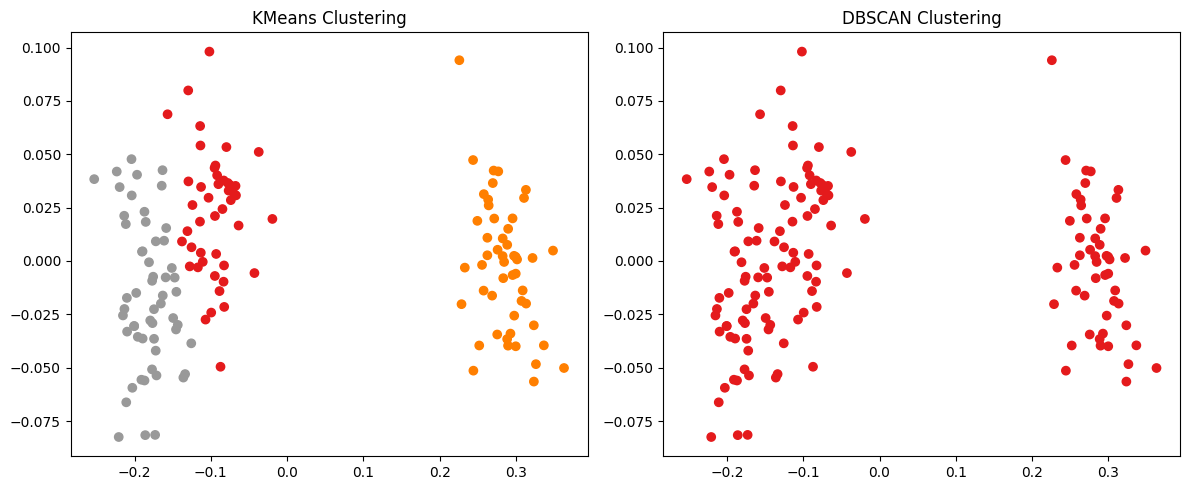

In [12]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Plot KMeans results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_kmeans, cmap='Set1')
plt.title('KMeans Clustering')

# Plot DBSCAN results
plt.subplot(1, 2, 2)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_dbscan, cmap='Set1')
plt.title('DBSCAN Clustering')

plt.tight_layout()
plt.show()
